# CS109b Final Project

# Milestone4
by Danqing Wang, Wenshan Zheng, Zecai Liang

In [2]:
import pandas as pd
import numpy as np
import urllib
from bs4 import BeautifulSoup
import time
import re
# Use package tmdbsimple to extract data
import tmdbsimple as tmdb
# use "!pip install tmdbsimple" to install
tmdb.API_KEY = '302f3815bea132a8bfe0d7301c9065dd'
import random
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import pickle

Using TensorFlow backend.


# Part 1 Data for Deep Learning

## 1.1 Further Group 'genres'

In [3]:
# read in genre information from MS1 - 3 and check
df_y = pd.read_csv('genre_final.csv', index_col=0)
genre_count = df_y.sum()
genre_count.sort()
genre_count

C:\Users\zhengguo\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


Other            311.0
Western          544.0
Sport            598.0
Biography        778.0
War              914.0
History          920.0
Short           1143.0
Animation       1369.0
Foreign         1613.0
Fantasy         1707.0
Mystery         1718.0
Sci-Fi          1828.0
Music           1848.0
Documentary     2264.0
Family          2281.0
Adventure       2454.0
Horror          2790.0
Crime           3072.0
Action          4274.0
Thriller        4639.0
Romance         4725.0
Comedy          8622.0
Drama          11598.0
dtype: float64

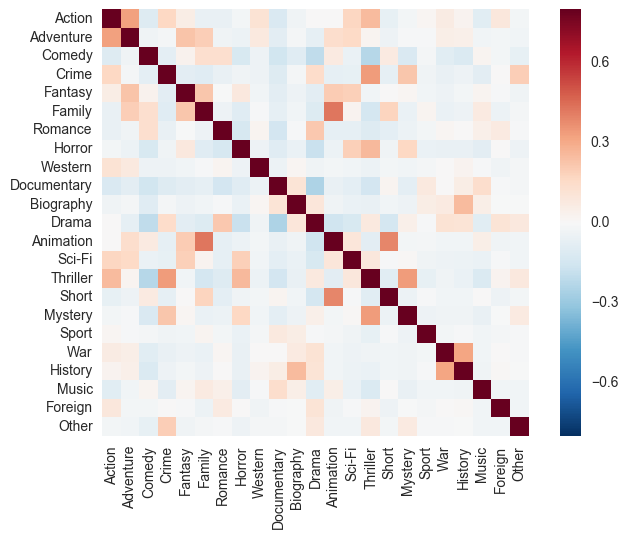

In [4]:
# correlation heatmap
df_corr = df_y.corr()
sns.heatmap(df_corr, vmax=.8, square=True)

Almost half of movies are in genre 'Drama' thus we try not to combine any other genre with it. With above correlation matrix and our common knowledge, we combine following genres into one:
    1. 'Action', 'Adventure' and 'Western'
    2. 'Music', 'Biography', 'History', 'War' and 'Documentary'
    3. 'Short', 'Animation' and 'Family'
    4. 'Foreign', 'Sport' and 'Other'.
    5. 'Fantasy' and 'Sci-Fi'
    6. 'Mystery', 'Crime', 'Horror' and 'Thriller'
    7. 'Romance' 
    8. 'Drama'
    9. 'Comedy'

In [5]:
# create a dataframe to store information of merged genres
index = df_y.index
column = ['Act_Adven_West', 'Mus_Bio_His_War_Doc', 'Sh_Ani_Fam', 'Fant_SF', \
           'Mys_Cri_Hor_Thr', 'Romance', 'Drama', 'Comedy', 'Other']
df_merged = pd.DataFrame(index = index, columns = column)
df_merged = df_merged.fillna(0)
df_merged.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy,Other
imdb_ids,,,,,,,,,
113101,0,0,0,0,0,0,0,0,0
425473,0,0,0,0,0,0,0,0,0
76759,0,0,0,0,0,0,0,0,0
266543,0,0,0,0,0,0,0,0,0
411267,0,0,0,0,0,0,0,0,0


In [6]:
for i in range(len(df_merged)):
    df_merged.ix[df_merged.index[i],'Act_Adven_West'] = max(df_y.ix[df_merged.index[i],'Action'], \
                                                            df_y.ix[df_merged.index[i],'Adventure'], \
                                                            df_y.ix[df_merged.index[i],'Western'])
    df_merged.ix[df_merged.index[i],'Mus_Bio_His_War_Doc'] = max(df_y.ix[df_merged.index[i],'Music'], \
                                                                 df_y.ix[df_merged.index[i],'Biography'], \
                                                                 df_y.ix[df_merged.index[i],'History'],\
                                                                 df_y.ix[df_merged.index[i],'War'], \
                                                                 df_y.ix[df_merged.index[i],'Documentary'])
    df_merged.ix[df_merged.index[i],'Sh_Ani_Fam'] = max(df_y.ix[df_merged.index[i],'Short'], \
                                                                 df_y.ix[df_merged.index[i],'Animation'], \
                                                                 df_y.ix[df_merged.index[i],'Family'])
    df_merged.ix[df_merged.index[i],'Fant_SF'] = max(df_y.ix[df_merged.index[i],'Fantasy'], \
                                                     df_y.ix[df_merged.index[i],'Sci-Fi'])
    df_merged.ix[df_merged.index[i],'Mys_Cri_Hor_Thr'] = max(df_y.ix[df_merged.index[i],'Mystery'], \
                                                             df_y.ix[df_merged.index[i],'Crime'],\
                                                             df_y.ix[df_merged.index[i],'Horror'], \
                                                             df_y.ix[df_merged.index[i],'Thriller'])
    df_merged.ix[df_merged.index[i],'Other'] = max(df_y.ix[df_merged.index[i],'Foreign'], \
                                                   df_y.ix[df_merged.index[i],'Sport'], \
                                                   df_y.ix[df_merged.index[i], 'Other'])
    df_merged.ix[df_merged.index[i],'Romance'] = df_y.ix[df_merged.index[i],'Romance']
    df_merged.ix[df_merged.index[i],'Drama'] = df_y.ix[df_merged.index[i],'Drama']
    df_merged.ix[df_merged.index[i],'Comedy'] = df_y.ix[df_merged.index[i],'Comedy']

In [7]:
# count of new genre 
genre_count = df_merged.sum()
genre_count.sort()
genre_count

C:\Users\zhengguo\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


Other                   2490.0
Fant_SF                 3091.0
Sh_Ani_Fam              3413.0
Romance                 4725.0
Mus_Bio_His_War_Doc     5222.0
Act_Adven_West          5616.0
Mys_Cri_Hor_Thr         7729.0
Comedy                  8622.0
Drama                  11598.0
dtype: float64

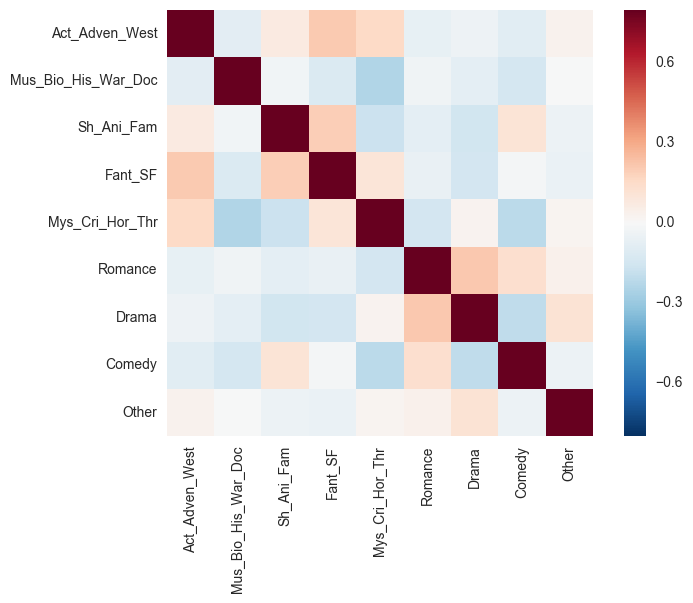

In [8]:
# heatmap of new genre
df_corr = df_merged.corr()
sns.heatmap(df_corr, vmax=.8, square=True)

In [9]:
# write out genre list
df_merged.to_csv('genre_merged.csv')

In [10]:
# read in genre dataframe
df_y = pd.read_csv('genre_merged.csv', index_col=0)
df_y.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy,Other
imdb_ids,,,,,,,,,
113101,0,0,0,0,1,0,0,1,0.0
425473,0,0,1,0,0,0,1,0,0.0
76759,1,0,0,1,0,0,0,0,0.0
266543,1,0,1,0,0,0,0,1,0.0
411267,0,0,0,0,1,0,0,0,0.0


In [11]:
# sample 150 movies from each genre
sample_list = [] # a list to store imdb_ids of genres
k = 150
for i in range(len(df_y.columns)-1):
    sample_list += random.sample(df_y.index[df_y[df_y.columns.values[i]] == 1], k)
# sample out 1000 movies from above
sample_list = list((set(sample_list)))
sample_list = random.sample(sample_list, 1000)

In [12]:
# write samples out imdb_id list
import csv
with open('imdb_ids_sample', 'wb') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(sample_list)

In [13]:
# read in balanced imdb_ids
sample_imdb_list = []
with open("imdb_ids_sample") as file:
    line = csv.reader(file)
    sample_imdb_list = list(line)
sample_imdb_list = sample_imdb_list[0]
sample_imdb_list = map(int, sample_imdb_list)

In [14]:
# create a dataframe to store information of merged genres for balanced imdb_ids
index = sample_imdb_list
column = ['Act_Adven_West', 'Mus_Bio_His_War_Doc', 'Sh_Ani_Fam', 'Fant_SF', \
           'Mys_Cri_Hor_Thr', 'Romance', 'Drama', 'Comedy', 'Other']
df_balance = pd.DataFrame(index = index, columns = column)
df_balance = df_balance.fillna(0)
df_balance.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy,Other
130529,0,0,0,0,0,0,0,0,0
361127,0,0,0,0,0,0,0,0,0
273790,0,0,0,0,0,0,0,0,0
110305,0,0,0,0,0,0,0,0,0
81376,0,0,0,0,0,0,0,0,0


In [15]:
# fill in genre values
for i in range(len(sample_imdb_list)):
    df_balance.ix[sample_imdb_list[i], ] = map(int, df_y.ix[sample_imdb_list[i], ])

In [16]:
# we are not predicting genre "Other"
df_balance = df_balance.drop('Other', axis = 1)
df_balance.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy
130529,0,1,0,0,0,0,0,1
361127,0,0,0,0,0,1,1,0
273790,0,1,0,0,0,0,0,0
110305,1,0,1,0,0,0,1,0
81376,0,0,0,0,1,0,0,1
59749,0,0,0,0,1,0,1,0
33152,1,0,1,1,0,0,0,0
1783772,0,1,0,0,0,0,0,1
37981,1,0,0,0,0,1,1,0
1158864,0,1,0,0,0,0,0,0


In [17]:
# write out genre information
df_balance.to_csv('genre_sample1.csv')

-------

In [18]:
# read in genre dataframe
genre = pd.read_csv('genre_sample.csv', index_col=0)
genre.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy
130529,0,1,0,0,0,0,0,1
361127,0,0,0,0,0,1,1,0
273790,0,1,0,0,0,0,0,0
110305,1,0,1,0,0,0,1,0
81376,0,0,0,0,1,0,0,1


## 1.2 Assemble Poster  Data

In [3]:
# read in sampled genre dataframe
genre = pd.read_csv('genre_sample.csv', index_col=0)
genre.head()

,Act_Adven_West,Mus_Bio_His_War_Doc,Sh_Ani_Fam,Fant_SF,Mys_Cri_Hor_Thr,Romance,Drama,Comedy
130529,0,1,0,0,0,0,0,1
361127,0,0,0,0,0,1,1,0
273790,0,1,0,0,0,0,0,0
110305,1,0,1,0,0,0,1,0
81376,0,0,0,0,1,0,0,1


In [5]:
for i in range(len(genre.index.values)):
    img_path='datapre/posters/' + str(genre.index.values[0]) + ".jpg"
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    np.save('npy/' + str(genre.index.values[i]), x.flatten())

In [6]:
# read in each image, use following code
# read in sampled genre dataframe
genre = pd.read_csv('genre_sample.csv', index_col=0)
genre.head()

# create a dataframe to store information of image
index = genre.index.values
column = ['values']
df_image = pd.DataFrame(index = index, columns = column)

for i in range(len(df_image)):
    df_image.ix[df_image.index.values[i], 'values'] = np.load('npy/' + str(df_image.index.values[i]) + '.npy')

# for vgg16, use df_image.values[i][0].reshape(1,224,224,3) to reshape dataset

---

# Part 2 Pre-trained Network

## 2.1 Baseline VGG16

## 2.2 Tune VGG16

---

# Part 3 Build From Scrath

In [1]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras import regularizers

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/CC/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## 3.1 Baseline MLP Model

In [ ]:
def base_MLP(batch_size, num_classes, epochs, unit, lr, momentum, 
             validation_ratio = 0.2, regularizer = None):

    ### ------- Baseline MLP - Layers ------- ###
    model = Sequential()
    # add an input layer
    model.add(Dense(unit, activation='relu', input_shape=(???,)))
    # this is our hidden layer
    model.add(Dense(unit, activation='relu', kernel_regularizer=None))
    # and an output layer
    model.add(Dense(num_classes, activation='sigmoid'))
    # prints out a summary of the model architecture
    #model.summary()

    ### ------- Baseline MLP - Optimization ------- ###
    sgd = SGD(lr=lr, momentum=momentum)  # momentum = [0.9, 0.99]
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    ### ------- Baseline MLP - Optimization ------- ###
    history = model.fit(x, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=validation_ratio)
    
    return history

In [ ]:
###### Baseline MLP - Parameters ######

MLP.model0 = base_MLP(batch_size = 128, num_classes = 10, epochs = 100, unit = 20, lr = 0.1, momentum = 0.9, 
             validation_ratio = 0.2, regularizer = None)

In [ ]:
### Baseline MLP - Evaluation ###
print(MLP.model0.history)

plt.plot(MLP.model0.history['acc'])
plt.xlabel("epoch")
plt.ylabel("accuracy")

## 3.2 Tune MLP Model

### 3.2.1 Add Regularization

In [ ]:
###### MLP - L2 Regularization ######

lambda_val = [0.01, 0.1, 1, 10] # values for lambda in regularization

MLP.model1 = base_MLP(batch_size = 128, num_classes = 10, epochs = 100, unit = 20, lr = 0.1, momentum = 0.9, 
             validation_ratio = 0.2, regularizer = regularizers.l2(0.01))

In [ ]:
###### MLP - L1 + L2 Regularization ######

lambda_val = [0.01, 0.1, 1, 10] # values for lambda in regularization

MLP.model2 = base_MLP(batch_size = 128, num_classes = 10, epochs = 100, unit = 20, lr = 0.1, momentum = 0.9, 
             validation_ratio = 0.2, regularizer = regularizers.l1_l2(0.01))

### 3.2.2 

In [ ]:
###### MLP - small batch_size ######

In [ ]:
###### MLP - more epochs ######

In [ ]:
###### MLP - Nodes for Each Layer ######

## 3.3 Visulize Features

In [ ]:
# Look at the weights of the first layer
layer = model.layers[0]
weights = layer.get_weights()

# make a figure for the first 10 filters
filterTiles = np.array([])
index = 0
for i in range(5):
    filterRow = []
    for j in range(2):
        w = weights[0][:,:,0,index]
        w = w.reshape(?,?)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

---

# Part 4 Discussion

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc.
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc.
- Discussion of the results, how much improvement you gained with fine tuning, etc.
- Discussion of at least one additional exploratory idea you pursued